<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RTML_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [3]:
# Calculate speed and distances
epsilon = 1e-5  # Small constant to avoid division by zero
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + epsilon)

In [4]:
# Handle potential infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)  # Fill NaNs with the mean of the column


In [5]:
# Normalize features
scaler = MinMaxScaler()
data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']] = scaler.fit_transform(
    data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']]
)

In [6]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps + 1
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix-1].to_numpy()
        seq_y = data.iloc[end_ix-1][['Latitude', 'Longitude']].to_numpy()
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Prepare sequences
grouped = data.groupby('Tag')
X, y = [], []
for _, group in grouped:
    sequences = create_sequences(group[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']], n_steps=5)
    X.append(sequences[0])
    y.append(sequences[1])

X = np.concatenate(X)
y = np.concatenate(y)


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5,32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Prepare data loaders
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()




Epoch 1: Training Loss: 0.0009922594111147077, Validation Loss: 4.341057028218601e-05
Epoch 2: Training Loss: 3.005995877964797e-05, Validation Loss: 1.4257593324246296e-05
Epoch 3: Training Loss: 2.2121447094120454e-05, Validation Loss: 1.818985679252431e-05
Epoch 4: Training Loss: 1.8686751151628382e-05, Validation Loss: 1.0679704909981429e-05
Epoch 5: Training Loss: 1.6805425560035547e-05, Validation Loss: 1.0027069559418502e-05
Epoch 6: Training Loss: 1.573792399731955e-05, Validation Loss: 2.4787122970166847e-05
Epoch 7: Training Loss: 1.4413344735205086e-05, Validation Loss: 2.5464402094402945e-05
Epoch 8: Training Loss: 1.3992453962112377e-05, Validation Loss: 1.333696219606687e-05
Epoch 9: Training Loss: 1.334548556623058e-05, Validation Loss: 1.544180631206924e-05
Epoch 10: Training Loss: 1.3060613433161626e-05, Validation Loss: 1.1769720301406478e-05
Epoch 11: Training Loss: 1.2487044874417615e-05, Validation Loss: 1.4889993474972869e-05
Epoch 12: Training Loss: 1.22033152275

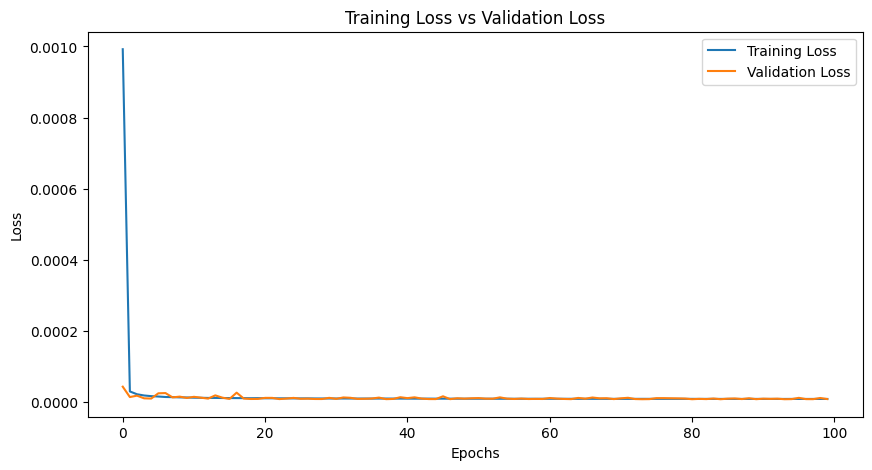

In [12]:
# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)

In [15]:
# Load Model Function
def load_model(model, load_path='model.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model

Actual: [-12.94924   33.229343], Predicted: [-12.949047  33.219433]
Actual: [-13.06287   33.132607], Predicted: [-13.069629  33.134014]
Actual: [-12.845263  33.225277], Predicted: [-12.848253  33.225914]
Actual: [-12.979793  33.342915], Predicted: [-12.979596  33.341965]
Actual: [-12.89023   33.258247], Predicted: [-12.889418  33.24642 ]
Actual: [-12.720785  33.006996], Predicted: [-12.725478  33.009483]
Actual: [-13.037052  33.227467], Predicted: [-13.03857   33.226467]
Actual: [-13.259257  33.158863], Predicted: [-13.259947  33.15805 ]
Actual: [-12.93738   33.231277], Predicted: [-12.938728  33.231403]
Actual: [-13.003025  33.131042], Predicted: [-13.004025  33.131763]

Average Loss: 8.586674069647795e-06
Latitude RMSE: 0.0037800742522654815, Longitude RMSE: 0.0034923231176482413


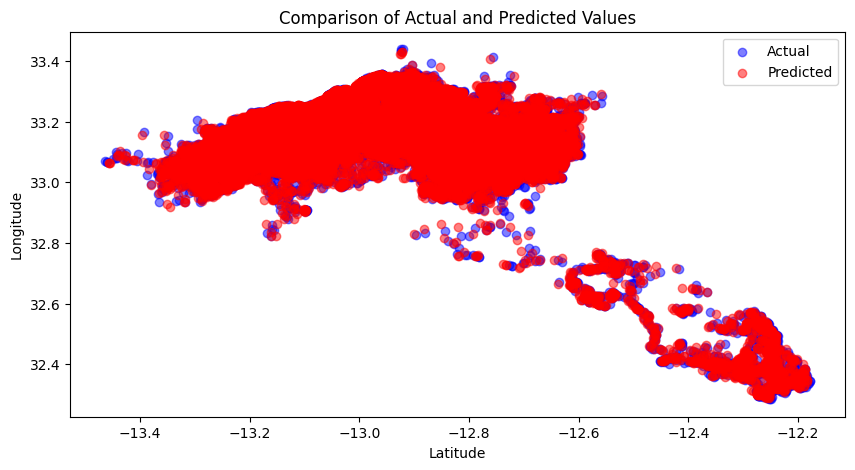

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [17]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.rnn = nn.RNN(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

rnn_model = RNNModel().to('cuda')
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.909484169567849e-06, Validation Loss: 8.870200495802782e-06
Epoch 2: Training Loss: 8.927714669824848e-06, Validation Loss: 8.276496593928048e-06
Epoch 3: Training Loss: 8.908813649253787e-06, Validation Loss: 8.866139163737921e-06
Epoch 4: Training Loss: 8.95211818653957e-06, Validation Loss: 8.6248967806235e-06
Epoch 5: Training Loss: 8.93686857948669e-06, Validation Loss: 9.808716990584598e-06
Epoch 6: Training Loss: 8.87058710844184e-06, Validation Loss: 9.790890873535025e-06
Epoch 7: Training Loss: 8.93806009615546e-06, Validation Loss: 8.809343792904752e-06
Epoch 8: Training Loss: 8.893218572243874e-06, Validation Loss: 8.064144343637114e-06
Epoch 9: Training Loss: 8.83691168652728e-06, Validation Loss: 8.454647979789414e-06
Epoch 10: Training Loss: 8.885588474359163e-06, Validation Loss: 9.149395865638467e-06
Epoch 11: Training Loss: 8.862717279167549e-06, Validation Loss: 9.355652358378394e-06
Epoch 12: Training Loss: 8.833612436643844e-06, Validation 

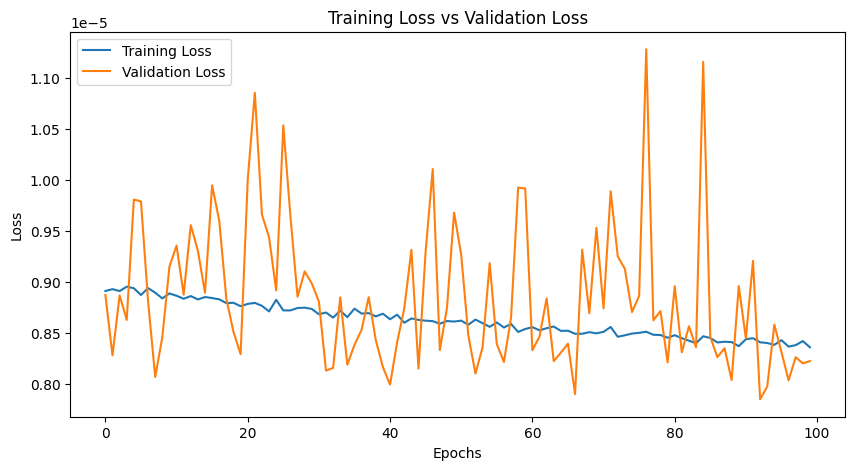

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_SimpleRNN.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_SimpleRNN.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-13.105893  33.158833], Predicted: [-13.106808  33.16078 ]
Actual: [-12.902918  33.019264], Predicted: [-12.915933  33.013103]
Actual: [-12.83952  33.18712], Predicted: [-12.840363  33.18885 ]
Actual: [-12.880815  33.24882 ], Predicted: [-12.886244  33.24289 ]
Actual: [-12.764773  33.285976], Predicted: [-12.7653475  33.285385 ]
Actual: [-12.83407   33.181904], Predicted: [-12.834812  33.181866]
Actual: [-12.658733  33.116253], Predicted: [-12.663146  33.11679 ]
Actual: [-13.255983  33.044838], Predicted: [-13.254713  33.043877]
Actual: [-12.847253  33.25937 ], Predicted: [-12.846007  33.252098]
Actual: [-13.178527  33.197525], Predicted: [-13.178947  33.195145]

Average Loss: 8.218789424643785e-06
Latitude RMSE: 0.0034972729134583004, Longitude RMSE: 0.0035929746152525617


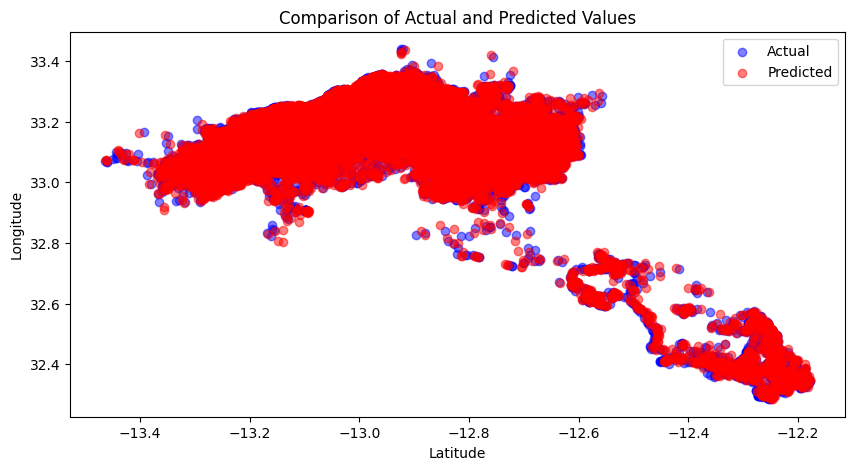

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [20]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.gru = nn.GRU(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

gru_model = GRUModel().to('cuda')
criterion_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.364278029445368e-06, Validation Loss: 8.323605547961212e-06
Epoch 2: Training Loss: 8.34974904390458e-06, Validation Loss: 8.455344315754447e-06
Epoch 3: Training Loss: 8.36013089134666e-06, Validation Loss: 9.35343959329018e-06
Epoch 4: Training Loss: 8.352057167424434e-06, Validation Loss: 8.637191968623867e-06
Epoch 5: Training Loss: 8.368585586725576e-06, Validation Loss: 7.874580417287684e-06
Epoch 6: Training Loss: 8.31584116202198e-06, Validation Loss: 8.027307229604079e-06
Epoch 7: Training Loss: 8.314271909945925e-06, Validation Loss: 8.225838854632943e-06
Epoch 8: Training Loss: 8.360378665290353e-06, Validation Loss: 8.391398447808266e-06
Epoch 9: Training Loss: 8.325811494222799e-06, Validation Loss: 8.593401317787203e-06
Epoch 10: Training Loss: 8.339187891918955e-06, Validation Loss: 1.0080134144044644e-05
Epoch 11: Training Loss: 8.347825749950429e-06, Validation Loss: 8.471406265340092e-06
Epoch 12: Training Loss: 8.36186850538845e-06, Validati

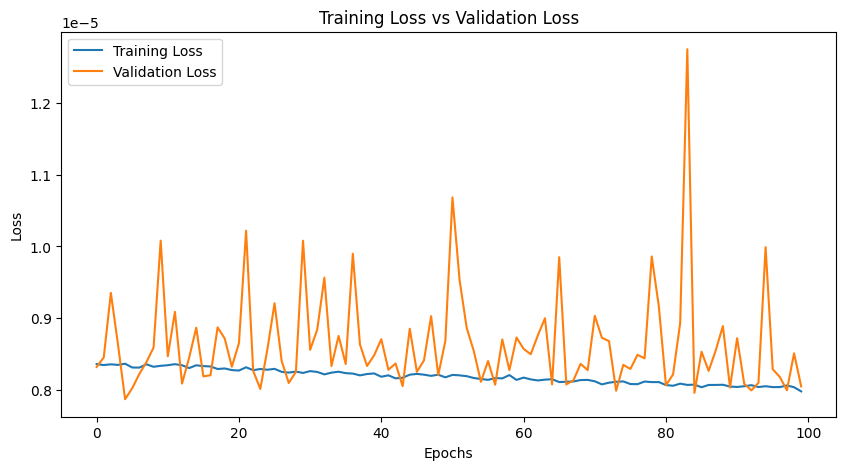

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_GRU.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_GRU.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.901502  33.304554], Predicted: [-12.891722  33.295444]
Actual: [-12.941708  33.215706], Predicted: [-12.9488325  33.212475 ]
Actual: [-13.228787  33.116093], Predicted: [-13.229701  33.11286 ]
Actual: [-13.174182  33.168346], Predicted: [-13.172318  33.17015 ]
Actual: [-12.89958  33.2035 ], Predicted: [-12.898974  33.20333 ]
Actual: [-12.951135  33.212532], Predicted: [-12.950853  33.211197]
Actual: [-12.914855  33.257057], Predicted: [-12.913502  33.25791 ]
Actual: [-13.293983  33.023006], Predicted: [-13.292282  33.023026]
Actual: [-13.188335  33.17178 ], Predicted: [-13.187992  33.17164 ]
Actual: [-12.897313  33.329346], Predicted: [-12.897597  33.33085 ]

Average Loss: 8.055307865212056e-06
Latitude RMSE: 0.0035392736700468014, Longitude RMSE: 0.0034909354739116197


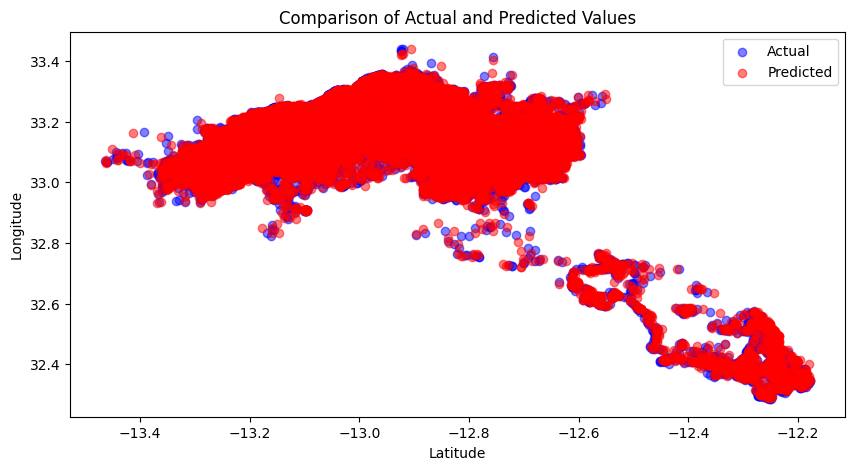

In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [23]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc_out(x[:, -1, :])

# Example initialization and setting up optimizer and loss
transformer_attention_model = TransformerModel(input_dim=5, num_heads=4, num_layers=3, hidden_dim=128, output_dim=2).to('cuda')
criterion_transformer = nn.MSELoss()
optimizer_transformer = torch.optim.Adam(transformer_attention_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.014123473627691e-06, Validation Loss: 8.476175349921901e-06
Epoch 2: Training Loss: 8.025102510404869e-06, Validation Loss: 8.34217134044985e-06
Epoch 3: Training Loss: 8.042263373122866e-06, Validation Loss: 8.047479523673325e-06
Epoch 4: Training Loss: 8.020945693036822e-06, Validation Loss: 8.026871385800443e-06
Epoch 5: Training Loss: 8.003094305966134e-06, Validation Loss: 8.202394981042899e-06
Epoch 6: Training Loss: 7.999678213039971e-06, Validation Loss: 8.265351417149176e-06
Epoch 7: Training Loss: 7.99620079077905e-06, Validation Loss: 8.336034752893171e-06
Epoch 8: Training Loss: 8.010101633671061e-06, Validation Loss: 8.332383807898038e-06
Epoch 9: Training Loss: 8.004355657892041e-06, Validation Loss: 8.60978176147612e-06
Epoch 10: Training Loss: 7.964989431919702e-06, Validation Loss: 8.023339837818518e-06
Epoch 11: Training Loss: 7.965061149243794e-06, Validation Loss: 8.49388971993323e-06
Epoch 12: Training Loss: 7.987978945708025e-06, Validati

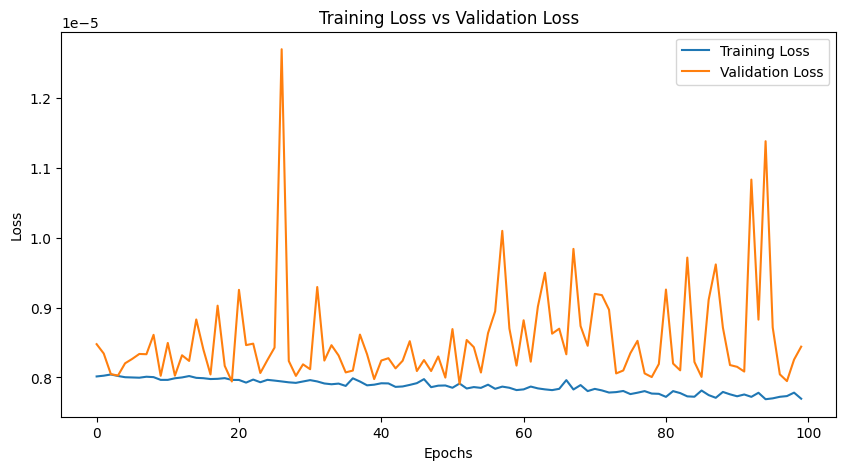

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_Transformer.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_Transformer.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-13.038712  33.176575], Predicted: [-13.030896  33.17861 ]
Actual: [-13.062852  33.268642], Predicted: [-13.063671  33.269577]
Actual: [-13.292553  33.06102 ], Predicted: [-13.294255  33.062706]
Actual: [-12.69358   33.134724], Predicted: [-12.6966915  33.13265  ]
Actual: [-12.709967  33.11487 ], Predicted: [-12.705967  33.113167]
Actual: [-13.027102  33.288013], Predicted: [-13.024657  33.288853]
Actual: [-12.836907  33.299816], Predicted: [-12.83707  33.30167]
Actual: [-12.927065  33.28504 ], Predicted: [-12.926931  33.28603 ]
Actual: [-12.827367  33.129562], Predicted: [-12.825943  33.128094]
Actual: [-12.862723  33.257053], Predicted: [-12.862751  33.25565 ]

Average Loss: 8.441984741811658e-06
Latitude RMSE: 0.0035528896891604132, Longitude RMSE: 0.0036338297805134493


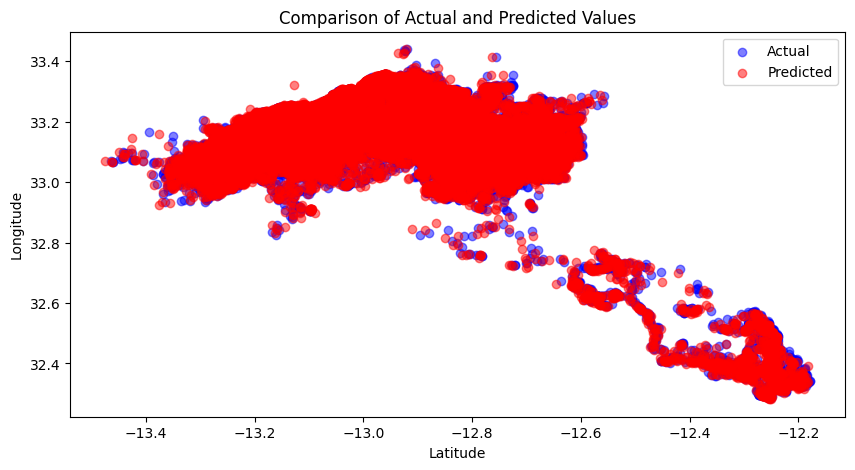

In [25]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)
